<a id="top"></a>
# Surveying dust structure via GALEX MIS - Part 2 - SOLUTION
***

Solutions proposed for Part 2.

## Imports

- `astropy` to use tools needed for performing astronomy and astrophysics with Python, including handling fits files, defining coordinates or choosing the right limits for image visualization.
- `Observations` from _astroquery.mast_ to query the Barbara A. Mikulski Archive for Space Telescopes (MAST).
- `os` to  use operating system dependent functionality, such as unzipping files.
- `matplotlib` to visualize images.
- `numpy` to manipulate arrays.
- `PIL` to combine multiple images together

In [1]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.mast import Observations
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from astropy.visualization import ZScaleInterval
import numpy as np
from PIL import Image, ImageDraw

## Functions

In [2]:
def getImCoord(coord_RA,coord_Dec, RA1, RAf, Dec1, Decf,image,extended_image):
    
    """
    Transforms coordinates in (RA, Dec) format into image coordinates to be used as input for the paste method from PIL
    Inputs:
    :param coord_RA, coord_Dec: coordinates of target (Right Ascension and Declination)
    :type coord_RA, coord_Dec: float
    :param RA/Dec1, RA/Decf: coordinate limits of image for the RA/Dec axis
    :type RA/Dec1, RA/Decf: float
    :param image/extended_image: 2D arrays corresponding to the image we want to correctly place and the extended image we will place it on
    :type image/extended_image: PIL Jpeg image file
    
    Outputs: 
    :return: ImCoord_RA, ImCoord_Dec - Image coordinates
    :rtype: float
    """
    
    RAx = np.array([RA1,RAf])
    pixx = np.array([-image.size[0]/2,extended_image.size[0]-image.size[0]/2])
    m_RA, b_RA = np.polyfit(RAx, pixx, 1)
    ImCoord_RA = m_RA*coord_RA+b_RA
    
    Decx = np.array([Dec1,Decf])
    pixy = np.array([extended_image.size[1]-image.size[1]/2,-image.size[1]/2])
    m_Dec, b_Dec= np.polyfit(Decx, pixy, 1)
    ImCoord_Dec = m_Dec*coord_Dec+b_Dec
    
    return ImCoord_RA, ImCoord_Dec

## Exercises

Now that we have seen the whole process, let's try to do the same for the same target, but this time let's use the NUV images instead of the FUV images.

Here are again the coordinates that SIMBAD provides for the [MBM 15](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=mbm+15&NbIdent=1&Radius=2&Radius.unit=arcmin&submit=submit+id) (Gal. coordinates, ep = J2000):

- Galactic longitude: 191.6657 deg
- Galactic latitude: -52.2938 deg

### 1. Coordinate query and data download

Following the steps shown before, perform a query in the GALEX MIS database and download the NUV intensity maps corresponding to the coordinates provided. Remember to choose a wide radius for the query in order to construct the final mosaic.

In [3]:
coord_gal = SkyCoord(191.6657, -52.2938, unit='deg', frame='galactic')
coord_icrs = coord_gal.transform_to('icrs')
obs = Observations.query_criteria(obs_collection="GALEX",coordinates=coord_icrs,project='MIS',radius="1 deg")
data_products = Observations.get_product_list(obs)
data_products_mrp = Observations.filter_products(data_products, productType='SCIENCE',productGroupDescription='Minimum Recommended Products')
filename = []
for i in range(1,len(data_products_mrp),2):
    yourProd = data_products_mrp[i]
    table = Observations.download_products(yourProd, mrp_only = False, cache = False) 
    filename.append(table['Local Path'][0])

In [4]:
n = len(filename)

images_mbm15 = []
header_mbm15 = []
RA1_mbm15 = np.zeros(n)
RAf_mbm15 = np.zeros(n)
Dec1_mbm15 = np.zeros(n)
Decf_mbm15 = np.zeros(n)
vmin_mbm15 = np.zeros(n)
vmax_mbm15 = np.zeros(n)
RAc_mbm15 = np.zeros(n)
Decc_mbm15 = np.zeros(n)

for i in range(n):
    os.system("gunzip " + filename[i])
    
    with fits.open(filename[i][:-3]) as hdulist: 
        header = hdulist[0].header
        header_mbm15.append(header)
        image = hdulist[0].data
        images_mbm15.append(image)
        
    naxis1 = header['NAXIS1']
    naxis2 = header['NAXIS2']
    cdelt1 = header['CDELT1']
    cdelt2 = header['CDELT2']
    crpix1 = header['CRPIX1']
    crpix2 = header['CRPIX2']
    crval1 = header['CRVAL1']
    RAc_mbm15[i] = crval1
    crval2 = header['CRVAL2']
    Decc_mbm15[i] = crval2
    
    # Initial RA - Pixel 1
    RA1_mbm15[i] = crval1 - (crpix1-1)*cdelt1/np.cos(crval2*(2*np.pi/360.0))
    # Final RA - Last Pixel 
    RAf_mbm15[i] = crval1 + (naxis1+1-crpix1)*cdelt1/np.cos(crval2*(2*np.pi/360.0))
    
    # Initial Dec - Pixel 1
    Dec1_mbm15[i] = crval2 - (crpix2-1)*cdelt2
    # Final Dec - Last Pixel 
    Decf_mbm15[i] = crval2 + (naxis2+1-crpix2)*cdelt2
    
    cut = image[1850:-1850,1850:-1850]
    interval = ZScaleInterval(nsamples=cut.size, contrast=0.75, max_reject=0.5)
    vmin_mbm15[i], vmax_mbm15[i] = interval.get_limits(cut)

_**Note**: don't forget to transform the coordinates from the galactic to the icrs frame!_

### 2. Check the orientation of the images

As we did before, check the orientation of the image and make the necessary adjustments if the orientations do not coincide:

In [5]:
for i in range(len(header_mbm15)):
    print('Image '+str(i+1)+': '+repr(header_mbm15[i][23:24]))

Image 1: CROTA2  =                   0.                                                  
Image 2: CROTA2  =                   0.                                                  
Image 3: CROTA2  =                   0.                                                  
Image 4: CROTA2  =                   0.                                                  
Image 5: CROTA2  =                   0.                                                  
Image 6: CROTA2  =                   0.                                                  
Image 7: CROTA2  =                   0.                                                  
Image 8: CROTA2  =                   0.                                                  
Image 9: CROTA2  =                   0.                                                  


### 3. Save non-central images to local

In order to use the `paste` method, we first need to save the additional images to our local. The central image is the fist one retrieved from the database, so let's save the rest of the images to our local directory in order to use them later. Remember you need to provide the filename which will be used to save the image to your local directory when using `savefig` from `matplotlib`.

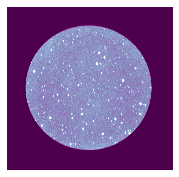

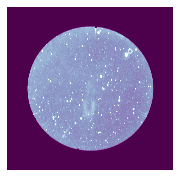

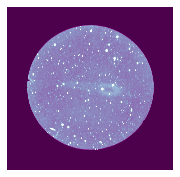

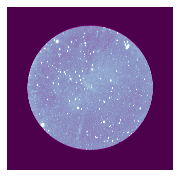

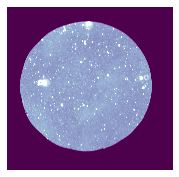

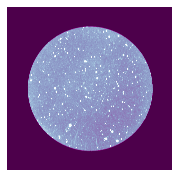

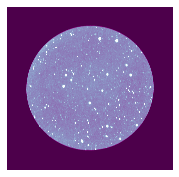

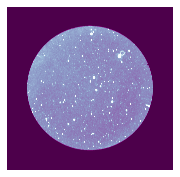

In [6]:
for i in range(1,len(RA1_mbm15)):
    plt.figure(figsize = (3,3),frameon=False)
    ax = plt.gca()
    ax.set_axis_off()
    plt.imshow(images_mbm15[i], extent=[RA1_mbm15[i], RAf_mbm15[i], Dec1_mbm15[i], Decf_mbm15[i]], vmin=vmin_mbm15[0], vmax=vmax_mbm15[0], cmap='BuPu_r',origin='lower',aspect=1)
    plt.savefig('mbm15_'+str(i)+'_sol.jpg',pad_inches=0,bbox_inches='tight')
    plt.show()

### 4. Generate the masks for the circular images

Since we are working with circular images, in order to paste them into our extended image we need to only use the part of the image that actually contains information. In order to do this, let's use circular masks as before. Create a circular mask for each of the images retrieved as shown previously.

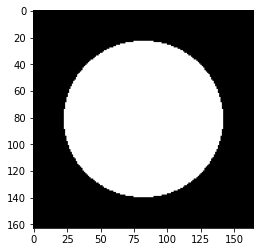

In [7]:
mask_im = []
n = len(filename)

for i in range(1,n):
    im2 = Image.open('mbm15_'+str(i)+'_sol.jpg')
    mask = Image.new("L", im2.size)
    size = mask.size
    draw = ImageDraw.Draw(mask)
    draw.ellipse((size[0]/7, size[1]/7, size[0]-size[0]/7, size[1]-size[1]/7), fill=255)
    mask_im.append(mask)

plt.figure()
plt.imshow(mask_im[0],cmap='binary_r')
plt.show()

### 5. Create an expanded image from the central one

Using the central image (the first one retrieved from the database), create an extended image by included 0s in the 2D array corresponding to the retrieved intensity map as we did before.

In [8]:
w = len(images_mbm15[0])
new_zeros = np.zeros((w,w))
new_image = np.append(images_mbm15[0], new_zeros, axis = 0)
new_image = np.insert(new_image,0,new_zeros,axis= 0)
new_zeros2 = np.zeros((w,3*w))
new_image = np.insert(new_image,0,new_zeros2,axis= 1)
new_image = np.insert(new_image,2*w,new_zeros2,axis= 1)

### 6. Obtain the limits of the expanded image and save it

Using the technique introduced in Part 1 of this tutorial, and briefly introduced in Part 2 also, obtain the new limits of the extended image we just created using the coordinates of the central image (RA, Dec).

In [9]:
naxis1 = header_mbm15[0]['NAXIS1']
naxis2 = header_mbm15[0]['NAXIS2']
cdelt1 = header_mbm15[0]['CDELT1']
cdelt2 = header_mbm15[0]['CDELT2']
crpix1 = header_mbm15[0]['CRPIX1']
crpix2 = header_mbm15[0]['CRPIX2']
crval1 = header_mbm15[0]['CRVAL1']
crval2 = header_mbm15[0]['CRVAL2']

# Initial RA - Pixel 1
RA1 = crval1 - (crpix1*3-1)*cdelt1/np.cos(crval2*(2*np.pi/360.0))
# Final RA - Last Pixel 
RAf = crval1 + (crpix1*3-1)*cdelt1/np.cos(crval2*(2*np.pi/360.0))

# Initial Dec - Pixel 1
Dec1 = crval2 - (crpix2*3-1)*cdelt2
# Final Dec - Last Pixel 
Decf = crval2 + (crpix2*3-1)*cdelt2

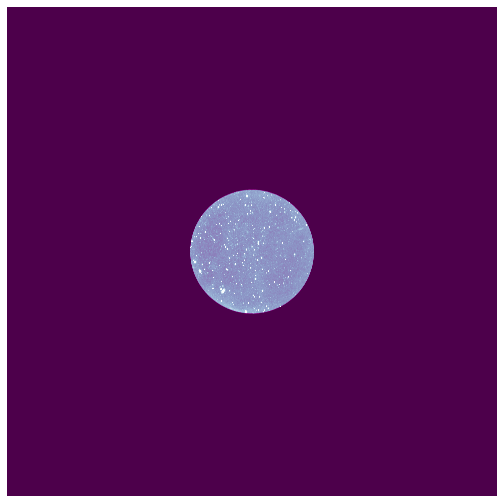

In [10]:
plt.figure(figsize = (9,9),frameon=False)
ax = plt.gca()
plt.imshow(new_image, vmin=vmin_mbm15[0], vmax=vmax_mbm15[0], cmap='BuPu_r',origin='lower')
ax.set_axis_off()
plt.savefig('expanded_sol.jpg',pad_inches=0,bbox_inches='tight')
plt.show()

### 7. Transform RA, Dec coordinates into image coordinates

Lastly, we need to transform the central coordiantes of the images in order to correctly place them in the mosaic. You can use the function proposed before in this section.

In [11]:
Im_RA = np.zeros(n)
Im_Dec = np.zeros(n)
im_exp = Image.open('expanded_sol.jpg')

for i in range(1,n):
    im = Image.open('mbm15_'+str(i)+'_sol.jpg')
    Im_RA[i], Im_Dec[i] = getImCoord(RAc_mbm15[i],Decc_mbm15[i], RA1, RAf, Dec1, Decf,im,im_exp)
    print('(RA, Dec) = ('+str(RAc_mbm15[i])+','+str(Decc_mbm15[i])+') deg -> ('+str(Im_RA[i])+','+str(Im_Dec[i])+')')

(RA, Dec) = (47.03868,-9.28933) deg -> (210.76610532728228,240.5109778665044)
(RA, Dec) = (48.69935,-10.32142) deg -> (43.47060017552576,345.6460203107365)
(RA, Dec) = (47.69339,-10.07866) deg -> (144.81077393820033,320.9169919277838)
(RA, Dec) = (48.17532,-9.32474) deg -> (96.2612591051593,244.11805850186602)
(RA, Dec) = (49.137562,-9.782941) deg -> (-0.6747736215329496,290.793233712351)
(RA, Dec) = (48.31,-8.21) deg -> (83.19362758665193,130.56377814425832)
(RA, Dec) = (46.7123985291,-9.07050037384) deg -> (243.63562395282133,218.21964471301294)
(RA, Dec) = (48.6315994263,-10.3081998825) deg -> (50.295777032735714,344.29933773995276)


### 8. Display the final mosaic

Let's put together everything and display the final mosaic!

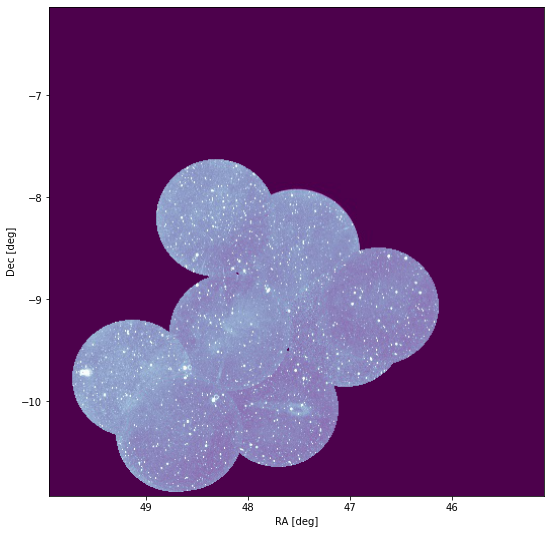

In [12]:
im_exp = Image.open('expanded_sol.jpg')

for i in range(1,n):
    im = Image.open('mbm15_'+str(i)+'_sol.jpg')
    im_exp.paste(im,(int(Im_RA[i]), int(Im_Dec[i])), mask_im[i-1])

plt.figure(figsize=(9,9))
ax = plt.gca()
plt.imshow(im_exp, extent=[RA1,RAf,Dec1,Decf],aspect=1)
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.savefig('mbm15_mosaic_sol.jpg',bbox_inches='tight',dpi = 1100)
plt.show()

As we can see in this image, the dust cloud that was clearly present in the FUV images, vaguely shows up in the NUV images. This is due to the fact that FUV images cover the wavelength range 900–2150 Å while NUV cover 1650-3200 Å, and since a good rule of thumb is that the dust size in the image is around the wavelength used for the observation, this serves us to put a preliminary upper limit to the dust grain size!

## Additional Resources

For more information about the MAST archive and details about the tutorial: 

* <a href="https://mast.stsci.edu/api/v0/index.html">MAST API</a> <br>
* <a href="https://galex.stsci.edu/GR6/">GALEX via MAST</a> <br>

## About this Notebook

**Author**: Clara Puerto Sánchez <br>
**Keyword(s)**: Tutorial, mosaic, dust <br>
**Last Updated**: Sep 2022 <br>
**Next review**: Apr 2023

For support, please contact the Archive HelpDesk at archive@stsci.edu.
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>